In [3]:
import os
import cv2
import numpy as np
import pathlib
from matplotlib import pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def show(data):
	plt.xticks([])
	plt.yticks([])
	plt.imshow(data)
	plt.show()

def printArrayInfo(arr):
	print("---------------------------")
	print("Size :: ", arr.size)
	print("Shape :: ", arr.shape)
	print("---------------------------")

In [6]:

dataDir = pathlib.Path("dataPostProcessed")
imageCount = len(list(dataDir.glob('*/*.jpg')))
print(imageCount)

batch_size = 64
img_height = 184
img_width = 187

12532


# Dataset

In [41]:
train_ds = tf.keras.utils.image_dataset_from_directory(
	dataDir,
	validation_split=0.2,
	subset="training",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

Found 12532 files belonging to 52 classes.
Using 10026 files for training.


In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
	dataDir,
	validation_split=0.2,
	subset="validation",
	seed=123,
	image_size=(img_height, img_width),
	batch_size=batch_size)

Found 12532 files belonging to 52 classes.
Using 2506 files for validation.


In [48]:
class_names = train_ds.class_names
for id, c in enumerate(class_names):
	class_names[id] = c.split("_")[0]
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Visualize

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
	for i in range(9):
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

# Performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.0 1.0


# Model

In [14]:
num_classes = len(class_names)

model = Sequential([
	layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes)
])

# Compile

In [16]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 184, 187, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 184, 187, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 92, 93, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 93, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        1

# Train

In [17]:
epochs=10
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs
)

Epoch 1/10
157/157 [==============================] - 143s 904ms/step - loss: 2.6473 - accuracy: 0.3553 - val_loss: 0.6888 - val_accuracy: 0.8140
Epoch 2/10
157/157 [==============================] - 138s 872ms/step - loss: 0.2164 - accuracy: 0.9442 - val_loss: 0.0803 - val_accuracy: 0.9781
Epoch 3/10
157/157 [==============================] - 138s 878ms/step - loss: 0.0323 - accuracy: 0.9916 - val_loss: 0.0764 - val_accuracy: 0.9820
Epoch 4/10
157/157 [==============================] - 144s 912ms/step - loss: 0.0320 - accuracy: 0.9930 - val_loss: 0.0243 - val_accuracy: 0.9944
Epoch 5/10
157/157 [==============================] - 172s 1s/step - loss: 0.0318 - accuracy: 0.9938 - val_loss: 0.0190 - val_accuracy: 0.9948
Epoch 6/10
157/157 [==============================] - 152s 970ms/step - loss: 0.0210 - accuracy: 0.9946 - val_loss: 0.0678 - val_accuracy: 0.9804
Epoch 7/10
157/157 [==============================] - 152s 969ms/step - loss: 0.0261 - accuracy: 0.9928 - val_loss: 0.0341 - va

# Viz

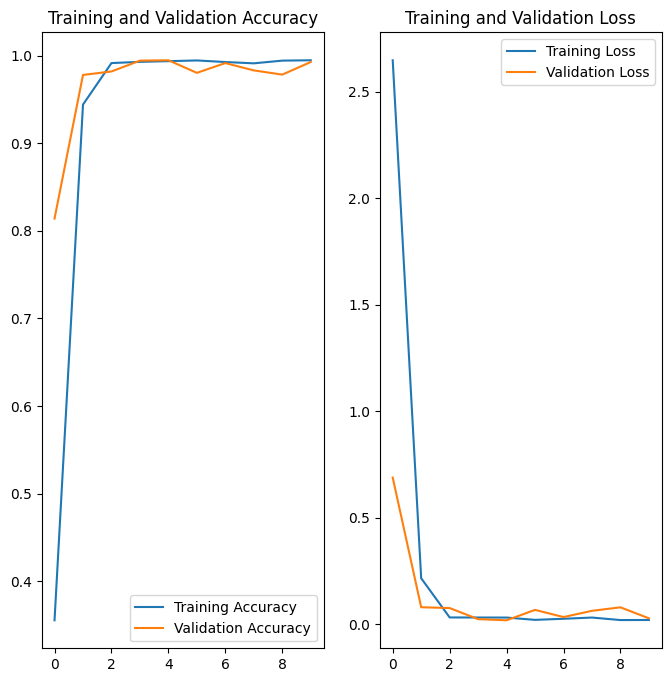

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 24ms/step
Score: 0.996127188205719 | Position: 19 | Letter: T


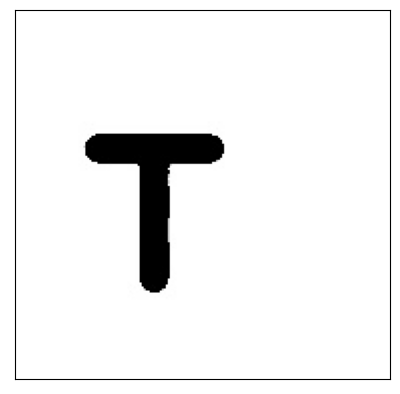

In [63]:
samplePath = pathlib.Path("dataTestProcessed/1_12_12.jpg")

img = tf.keras.utils.load_img( samplePath, target_size=(img_height, img_width) )
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Score: {} | Position: {} | Letter: {}".format(np.max(score), np.argmax(score), class_names[np.argmax(score)]))
show(img)